In [20]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time

def evol(output="bank_testdata.csv"):
    iot_data = pd.read_csv('bank_cleaned_pretest.csv')
    y = iot_data['y'].values
    X = iot_data[['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values
    start = time.time()
    pop, pareto, logbook = gsvm.gsvm(nqubits=4, depth=3, nparameters=1,
                                     X=X, y=y, weights=[-1.0,1.0],
                                     mu=50,lambda_=10, ngen=500)
    print(f'Simulation finished after {time.time()-start} seconds')
    print(f'\nGenetic-algorithm output ({output})')
    #print('generation, individual, gates/qubit, accuracy')
    print('---------------------------------------------')
    with open(output, "w") as f:
        for ide, ind in enumerate(pareto):
            genes=''.join(str(i) for i in list(ind))
            gates, acc = ind.fitness.values
            line = f'{ide},"{genes}",{gates},{acc}'
            f.write(line)
            f.write('\n')
            print(line)
evol()

multi
String: 110000000111010100111101001000011000011000111100111100111011
 -> accuracy = 0.9782608695652174, gates = 8.0
String: 110100010111110010101110010111111100110110101001110111010011
 -> accuracy = 0.9782608695652174, gates = 10.0
String: 000100011101111000010111010011100101110001010101010010011000
 -> accuracy = 0.9782608695652174, gates = 11.0
String: 100101010110001001100101000111101010010110101001110110001110
 -> accuracy = 0.9782608695652174, gates = 12.0
String: 110100110111100001110101010111111001100000110011111001001100
 -> accuracy = 0.9782608695652174, gates = 10.0
String: 010011111100100110011001100000111100000101000110111011000001
 -> accuracy = 0.9782608695652174, gates = 8.0
String: 001100000010101000101000001111101010110011101011100001111001
 -> accuracy = 0.9782608695652174, gates = 10.0
String: 010111001100000111101000110011001011010101101101110000010010
 -> accuracy = 0.9782608695652174, gates = 10.0
String: 1111111011111111110100001011100000010110110101001100

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


String: 101000001110010110010111110101011010101111111000010000001011
 -> accuracy = 0.9782608695652174, gates = 7.0
String: 111010100101111111010101100110001110110110001010101110000011
 -> accuracy = 0.9782608695652174, gates = 11.0
String: 111000011011001011111110110100101111111110110101010110100110
 -> accuracy = 0.9782608695652174, gates = 9.0
String: 001110001011110100100100101100110000110000111000001111111101
 -> accuracy = 0.9782608695652174, gates = 12.0
String: 010000100101110101000101101000101100111010000100100111011110
 -> accuracy = 0.9782608695652174, gates = 6.0
String: 000101100101011100001000010110000010010110110111011000011000
 -> accuracy = 0.9782608695652174, gates = 8.0
String: 001101101011100001111101110010000101111011001010000011010111
 -> accuracy = 0.9782608695652174, gates = 10.0
String: 100100111110011100101110110010000100000111111111110000011001
 -> accuracy = 0.9782608695652174, gates = 11.0
String: 100000111011100001100100000000100010010010000010101001001010

In [21]:
import encoding2 as e2
import random

iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,0,0101101000101111010001011010100100010110010001...,0.0,0.978261
1,1,0101101000101111010001011010010100010110010011...,0.0,0.978261
2,2,0101101000101111010001010010110100011010010011...,0.0,0.978261
3,3,1101101000101111010001011010100100010110010001...,0.0,0.978261
4,4,0101101000101111010001010010000100101010010001...,0.0,0.978261
...,...,...,...,...
1456,1456,0101111000110101010001010010101100010100010011...,0.0,0.978261
1457,1457,1101111000110111010001011010010100101000010011...,0.0,0.978261
1458,1458,0100101001101100101101010101000100001000010011...,0.0,0.978261
1459,1459,0101111000110101010001010010101100010100010000...,0.0,0.978261


['01011', '01000', '10111', '10100', '01011', '01010', '01000', '10110', '01000', '10110', '10100', '11010']
0.0


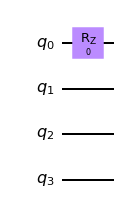

In [22]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
#from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))
        
cc = CircuitConversor(nqubits=4, nparameters=1)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [28]:
iot_data = pd.read_csv('bank_cleaned_pretest.csv')

y = iot_data['y'].values
X = iot_data[['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


In [31]:

train_sample, train_label, test_sample, test_label = fitness.Dataset(X,y)


In [55]:
cc_0 = encoding.CircuitConversor(nqubits=4, nparameters=1)
fm1, puertas1 = cc_0(iot_salidas.circ[0],np.array([0,1]))
model = qsvm.QSVM(fm,train_sample,train_label)

TypeError: 'QuantumCircuit' object is not callable

In [58]:
puertas1

0.0